# Processamento de Linguagem Natural

Vou abordar o conteito de processamento de linguagem natural ou [PLN](https://pt.wikipedia.org/wiki/Processamento_de_linguagem_natural). Esta é uma das técnicas que o Google utiliza para interpretar o que foi escrito na barra de busca dele. Geralmente outros buscadores fazem isto também, mas o google é o mais utilizado.

Como ele faz para entender o que você esta querendo dizer?? Bom: Processamento de Linguagem Natural.
Com a PLN o google pode trazer os resultados mais relevantes para sua pesquisa, assim como o Google Home, Alexa ou Siri fazem para entender o que você esta falando... Tudo isso é processamento de linguagem natural.

Vamos iniciar desenvolvendo um analisador de sentimentos através da NPL(Natural Processing Language), mas como isso funciona??

Imagina que você quer assistir um filme então você vai lá e busca criticas sobre o filme por exemplo no site [Adoro Cinema](http://www.adorocinema.com/). Esta critica do filme você vai interpretar e aí você irá classificar como bom ou ruim, ou com estrelas... **E é exatamente isto que nosso algorítmo irá fazer: Classificar críticas de filmes**.

Para isso vamos:

* Importar uma base de dados já classificada.
* Criar um modelo de machine learn capaz de interpretar a lingaugem humana e classificar este texto (atráves de *WORD CLOUDS*).
* Pré processamento de texto para torna-lo mais preciso.
* Usar a distribuição de pareto para ajudar na análise de dados.
* Realizar Tokenização com o [NLTK](https://www.nltk.org/)

## Começando

Vamos usar uma base de dados do IMDB disponível do [kaggle](https://www.kaggle.com/) 

In [1]:
import pandas as pd
#para que os algorítmos peguem sempre a mesma semente
import numpy as np 
np.random.seed(42)


Se for necessário baixe o `.csv` aqui: 

https://www.kaggle.com/luisfredgs/imdb-ptbr

In [2]:
resenha = pd.read_csv('./dados/imdb-reviews-pt-br.csv')


In [3]:
resenha

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos


## Usando o sklearn

Dentro da biblioteca sci-kit learn no módulo **model_selection** tem uma função chamada `train_test_split` que faz justamente o que precisamos: 

* Reservar dados para treinar o modelo.
* Reservar dados para testar o modelo 

Esta função esta disponível aqui: 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Como argumento a função `train_test_split` recebe: `data_x`, `data_y`, `test_size`

O retorno dela é: `x_treino`, `x_teste`, `y_treino`,`y_teste`

Em alguns lugares a coluna $y$ é chamada de classificador porque entendemos o modelo como uma função $f()$. Desta forma temos $x_{treino}$ que sera aplicado no modelo $f()$ e irá gerar o $y_{treino}$ tal que: 

$y_{treino} = f(x_{treino})$

Com o $y_{treino}$ comparamos com o $y_{teste}$. Ou seja, $y$ é a classificação do conjunto de dados de teste

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
x_treino, x_teste, classe_treino, classe_teste = train_test_split(resenha.text_pt,
                                                                  resenha.sentiment,
                                                                  random_state = 42)

# Usando o SKlearn Linear Model Logistic Regression 

O modelo de regressão linear usando a função logistica. A função [logistica](https://en.wikipedia.org/wiki/Logistic_function) ou também conhecida como função logística, até sigmoide, é uma curva em forma de "S"

<img src='./images/Logistic-curve.png' >

É sabido na literatura que a curva logistica é usada como classificador de uma logistic regression, maximum-entropy classification e linear-log classification.

Este modelo esta disponível em: 

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
#instanciando modelo
regressao_logistica = LogisticRegression()
#treinando modelo
regressao_logistica.fit(x_treino, classe_treino)
#testando o modelo: acuracia 
acuracia = regressao_logistica.score(x_teste, classe_teste)
#exibindo acuracia
acuracia

ValueError: could not convert string to float: 'Embora o filme tenha sido apenas assim, o closed caption foi de longe o melhor que eu já vi! Na maioria das vezes, a ortografia é terrível e a legenda está fora de sincronia. Eu uso o closed captioning mesmo que eu possa ouvir bem, mas acho que muitos atores resmungam. Também muitas vezes a trilha sonora substitui o diálogo. Obrigado!'

# NOTE O ERRO: 

O erro acima indica que o modelo não consegue converter uma `string` em `float`. É neste ponto em que entra o NLP entra, pra fazer a conversão entre linguagem natural para uma linguagem de máquina.

## Mas antes:

Temos que salientar alguns pontos de NLP. 

Primeiro, precisamos conhecer nossa base de dados, ou seja os textos. Se são longos ou curtos, como ela se comporta, se temos dicas que podem existir no texto para os classificadores para ajudar a definir se é positivo ou negativo. 

Por exemplo: `Filme ok` essa resenha é dificil de classificar, mas esta `Filme ok :(` é mais fácil, pois temos uma carinha triste `:(`. Outro exemplo seria `Filme ok :)`

Bom mas isso aqui não é o que aparece na nossa base de dados, nós temos textos longos, que precisam ser submetidos à uma análise mais fina.


In [8]:
print('Negativa\n')

print(resenha.text_pt[189])

Negativa

Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.


In [9]:
print('Positivo\n')

print(resenha.text_pt[49002])

Positivo

Crescendo em Nova York no final dos anos 80 e início dos anos 90, posso dizer pessoalmente que este é um dos documentários mais importantes feitos para cobrir esse lugar neste período de tempo. Não Madonna não veio com a idéia de Voguing, mas é de onde ela tirou! Em vez de combater a violência uns dos outros ou em brigas de gato, o voguing permitia que as pessoas "lutassem" dentro dos confins de tudo, menos que tocassem umas às outras, o que justificaria uma desqualificação automática. Vendo este tipo de extraordinariamente talentosas / bem orquestradas "jogadas" nos clubes foi nada menos do que espetacular e todos os grandes nomes de antigamente estão aqui ... Pepper La Beija, Paris Duprée, Xtragavaganza, etc. ..tudo comemorado nos gostos de peças de época como a música de Malcom McLarens "Deep in Vogue" ... não importava quem você era, ou de onde você era porque quando você passava por aquelas portas nesse "reino mágico" de De certa forma, você se tornou parte de algo maior

É importante ler um pouco sobre a base de dados, pois prá nós é simples ler um texto e extrair a opinião superficial da pessoa que o escreveu, mas isso não é tão fácil para o computador. Por isso ao ler podemos identificar algumas características de filmes classificados com positivos e negativos, por exemplo a palavra `'pior'` ou `'BRILHANTE!!!'`

# outro ponto importante:

A quantidade de dados. Não é novidade que para aprendizado de máquina seja necessário muitos dados, nossa base por exemplo tem 50K resenhas, mas pra que nosso modelo não seja enviesado é DE SUMA IMPORTÂNCIA que os dados sejam equivalentes, ou seja, a mesma quantidade de negativos tenha de positivos ou que pelo você faça um pré processamento para que ele fiquem balanceados. Isso é importante porque evita que o modelo fique enviesado e comece a achar que a maioria das resenhas são positivas ou negativas... 

In [10]:
# A quantidade de avaliações positivas e negativas:
resenha.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

In [11]:
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


# Aletarndo para classificação binaria

Note que temos avialiação de sentimentos como `neg` e `pos`. Então vamos vazer um mapeamento de `neg → 0` e `pos → 1`.

In [12]:
classificacao = resenha['sentiment'].replace(['neg','pos'],[0,1])

In [13]:
classificacao

0        0
1        0
2        0
3        0
4        0
        ..
49454    1
49455    1
49456    1
49457    1
49458    1
Name: sentiment, Length: 49459, dtype: int64

In [14]:
resenha['classificacao'] = classificacao

In [15]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


Agora já transformamos um dado textual em numérico sem perder o sentido.


# Processamento de Lingugagem Natural

É uma subárea da inteligência artificial que se preocupa em estudar a estrutura que gerencia a comunicação entre linguagem natural (humanos, português, inglês...) e a linguagem de máquina (computador, bits).

Dentro da PLN existe a analise textual, análise de sentimentos por texto, por imagens, enfim, várias outras subáreas...

## Vamos transformar texto em linguagem de máquina:

Quando temos as frases, ou melhor, na linguagem de PLN, o *corpus*:

    O filme é muito bom.
    O filme é muito ruim.
    
No nosso caso, todas as resenhas compõe nosso *corpus textual*. Neste exemplo acima, nosso corpus textual é bem mais simples. Similar ao meu post ["Isso é ou não um porquinho"](https://medium.com/@opolidordelentes/isso-%C3%A9-porquinho-ou-cachorrinho-f65bfd0215b4), podemos estratificar essa frase e atribuir uma classificação binária a cada palavra... 

Vamos criar um **Vocabulário**. Este vocabulário vai ter todas as minhas palavras mas sem repetições.

Aplicando a função `split()` nas frases por exemplo, temos:
```
['O', 'filme', 'é', 'muito', 'bom']
['O', 'filme', 'é', 'muito', 'ruim']
```

adicionando os elementos dessa lista em um `set()` temos:
`['O', 'filme', 'é', 'muito', 'bom', 'ruim']`
Então montamos uma matriz, com as letras sendo as colunas: 

<img src='./images/vocabulario.png' width=50%>

Ou seja, cada frase pode ser representada por um **vetor** e de forma bem simples podemos classificar uma frase como **boa** ou **ruim**. Apesar de ser uma forma simples é muito poderosa, então use abuse deste método de usando nas colunas variáveis linearmente independentes.

Mas e a frase: 
    
    O filme é muito muito bom.
    
como podemos enfatisar uma palavra?? Bom podemos fazer da seguinte maneira: 

<img src='./images/vocabulario_com_palavra_dupla.png' width=60%>

Essa forma vetorial de tratar frases pode ser uma forma bem eficiente além de modelar uma frase, consegue inferir uma intensidade a cada palavra! Para saber mais sobre esta representação procure por **"Sacola de palavras" ou [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model)**.


# Vamos então criar nosso Bag of Words:

Nosso dataset do IMDB possui quase 50 mil registros. Esse é um conjunto de dados grande e pidemos utilizar um dataframe do pandas parada guardar as informações dele.

Como acabamos de ver uma bag of words cria um label para cada palavra e caso isso se aplique no nosso dataset é provavel que tenhamos mais elementos *nulos* do que elementos preenchidos, quando isso acontece chamamos essa matriz de **matriz esparsa** ou **[sparce matrix](https://en.wikipedia.org/wiki/Sparse_matrix)**

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/0fce3708488472b34a85f11f54d8df3eeab1aabc'>

Não é muito eficiente armazenar toda a matriz, porque alocar valores 0 (zero é diferente de null) pode ser um desperdicio de memória e em alguns casos levar ao **[overflow](https://en.wikipedia.org/wiki/Buffer_overflow)**, por isso cuidado ao trabalhar com matrizes esparsas. Para isso o pandas tem uma estrutura especial para trabalhar com matrizes esparsas, essa estrutura armazena apenas os valores diferentes de zero em uma entidade de controle.

Nós vamos usar o `DataFrame.sparse.from_spmatrix` do pandas, para usar o `DataFrame.sparse.from_matrix` passamos como parâmetro:

```
pandas.DataFrame.sparse.from_matrix(bag_of_words, columns=vetorizar.get_feature_names())
```
Então o `DataFrame.sparse.from_matrix` recebe uma matriz esparsa (variável matriz_esparsa) e nos retorna um Dataframe (variável do tipo dataframe). Para mais informações busque em: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sparse.from_spmatrix.html

A principio vamos utilizar o objeto `CountVectorizer()` que cria um modelo que irá vetorizar as palavras que são passadas à ele pela fução `.fit()`

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
texto = ['Assisti um filme ótimo', 'Assisti um filme ruim']

# vetorizar porque esse objeto é responsável por vetorizar frases
vetorizar_frase = CountVectorizer(lowercase=False)

#contruindo sacola de palavras
bag_of_words = vetorizar_frase.fit_transform(texto)

In [18]:
vetorizar_frase.get_feature_names()

['Assisti', 'filme', 'ruim', 'um', 'ótimo']

In [19]:
bag_of_words

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [20]:
matriz_sparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words,
                                                  columns=vetorizar_frase.get_feature_names())
matriz_sparsa

,Assisti,filme,ruim,um,ótimo
0,1,1,0,1,1
1,1,1,1,1,0


é importante usar o objeto `DataFrame.sparse.from_spmatrix` para construir a matriz sparsa 


# Aplicando em nosso database

In [21]:
# vetorizar porque esse objeto é responsável por vetorizar frases
vetorizar_frase = CountVectorizer(lowercase=False, max_features=50)

#contruindo sacola de palavras
bag_of_words = vetorizar_frase.fit_transform(resenha.text_pt)

print(bag_of_words.shape)

(49459, 50)


Note que este vetor de dimensão $(49459, 156923)$ é caro computacionalmente falando... Um jeito de contornar esse problema **com perda de informação** é ao instanciar o `CountVectorizer()` passar o parâmetro `max_features` isso vai limitar a ordem do vetor que será retornado e ele só irá retornar as palavras que mais aparecem...

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [22]:
# separando os dados em treino e teste
treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, 
                                                             resenha.classificacao,
                                                             random_state=42)
# ajustando o modelo 
regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia = regressao_logistica.score(teste, classe_teste)
acuracia

0.6583097452486858

In [23]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    
    vetorizar_frase = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar_frase.fit_transform(texto[coluna_texto])
    
    #separando em dados de treino e testo:
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, 
                                                                 texto[coluna_classificacao],
                                                                 random_state=42)
    # ajustando o modelo 
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)


print(classificar_texto(resenha,"text_pt", "classificacao"))
    

0.6583097452486858


Como agora já temos a precisão do modelo pra determinar qual a taxa de acerto de um dado filme, vamos colocar as palavras com maior representatividade semântica na classificação de um filme sendo "bom" ou "ruim" estejam mais proximas o possível das *50 features* selecionadas pelo modelo através do parâmetro `max_features`. Para ter uma ideia melhor de quais são as 50 features mais "relevantes" do nosso corpus textual vamos usar uma técnica chamada **word_cloud**.

# Word Cloud

Você provavelmente já viu uma **word cloud** em algum site, buzzfeed por exemplo. Se não viu recomendo que use mais a internet (kkkkk) mas se você não reconhece pelo nome, talvez reconheça pela imagem:

<img src='./images/word-cloud.png'>

Em outras palavras, uma ***word cloud*** é uma imagem gerada com as principais palavras de um texto distribuídas em um espaço, de modo que o tamanho de cada palavra é proprocional à sua ***frequência*** de aparição no conjunto de dados. Ela ajuda cientistas de dados da área de processamento de linguagem natural a melhorar o resultado dos seus modelos. Com essa proporção da palavra com a frequência fica relativamente fácil identificar quais palavras são mais importantes num database.

Existe um repositório do github com um nome que não é tão intuitivo para gerar wordcloud, o repositório é este aqui: [repositório](https://github.com/amueller/word_cloud)

Já a documentação desta biblioteca esta disponível [aqui](http://amueller.github.io/word_cloud/) 

A função que vamos utilizar se chama `wordcloud()` a descrição desta função esta aqui: 
http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud

Ela recebe como parâmetro uma lista contendo todas as palavras a serem utilizadas pra construção da wordcloud:

Eu tentei rodar com todas as palavras na séries `resenha.text_pt` entretanto são, ao realizar o algorítmo 

```
todas_as_palavras = ''.join([texto for texto in resenha.text_pt])
```


são retornadas 63 milhões palavras, o esforço computacional pra isso é muito alto. Portanto talvez seja necessário fazer apenas com 60% das frases contidas em `resenha.text_pt` que são 37 milhões de palavras. Selecionando amostras aleatórias com o `sample()` ou com uma % menor do dataset.

In [24]:
%matplotlib inline

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#60% das resenhas.text_pt
#amostra_da_resenha = int(len(resenha.text_pt)*0.6)
# atraǘes desta list comprehencion vamos contruir uma lista contendo todas as resenhas.
#mas queremos UMA LISTA COM TODAS AS PALAVRAS, não com as frases. Então usamos o ' '.join(lista)
todas_as_palavras = ' '.join([texto for texto in resenha.text_pt])



# Aqui vem uma discussão importante: 
nuvem_de_palavras = WordCloud(width=800, # alterar width e height não alera o tamanho
                              height=500, # da imagem apenas a área distribuição das palavras
                              max_font_size=110, # altera o tamanho de cada fonte na wordcloud
                              collocations=False).generate(todas_as_palavras)


In [26]:
# no que é um objeto
nuvem_de_palavras

Vamos plotar esse objeto com o matplotlib

<function matplotlib.pyplot.show(*args, **kw)>

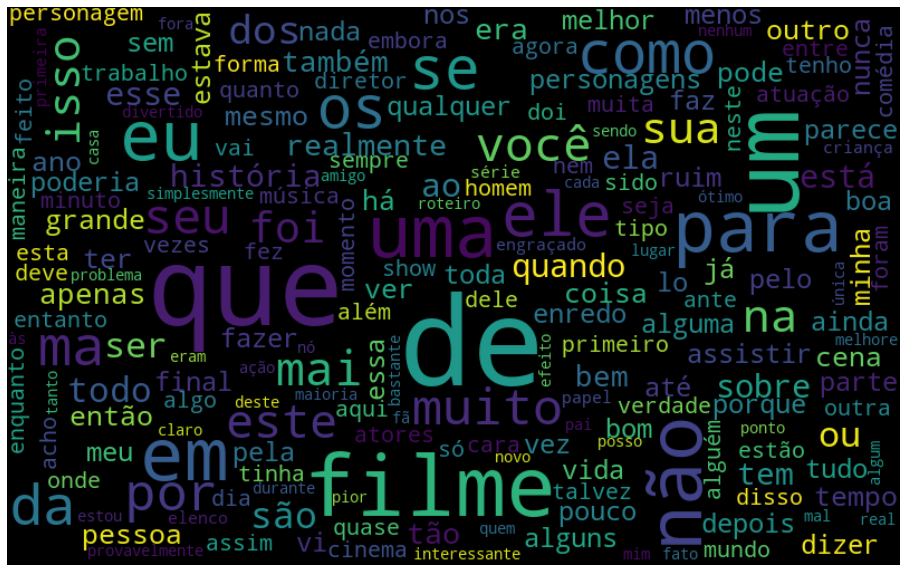

In [27]:
plt.figure(figsize=(16,16))
plt.imshow(nuvem_de_palavras, interpolation='bilinear')
plt.axis('off')
plt.show

## Analisando a Word Cloud 

Podemos notar que as palavras "não","para","que","filme","de" são palavras que aparecem em maior destaque na wordcloud, mas séra que elas realmente ajudam a classificar se um filme é bom ou ruim?? Provávelmente não, e é exatamente esta função da WORD CLOUD! Nos ajudar a verificar se as palavras que estão sendo escolhidas como "mais relevantes" são realmente suficientes pra determinar se um filme é bom ou ruim, e melhorar os resultados. 

### Outro ponto

Faz sentido olhar para as palavras "positivas" e "negativas" ao mesmo tempo?? Até certo ponto pode fazer sentido, mas talvez seja melhor olhar para as plavras "positivas" separada das "negativas", assim é possível fazer uma analise mais fina de como o algorítmo esta analisando as palavras pra classificar um comentário... 

### Fazendo consulta no Dataframe: Resenha

Como queremos semparar as palavras cuja classificação foi positiva e outra negativa, podemos filtrar nosso dataframe usando o método `query()` que faz uma consulta. A documentação do método query diz que "consulta as colunas de um Data Frame com expressões booleanas"

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html

In [32]:
resenha.query('sentiment == "pos"')

,id,text_en,text_pt,sentiment,classificacao
12389,12391,I went and saw this movie last night after bei...,Eu fui e vi este filme ontem à noite depois de...,pos,1
12390,12392,Actor turned director Bill Paxton follows up h...,"O diretor do ator, Bill Paxton, segue sua prom...",pos,1
12391,12393,As a recreational golfer with some knowledge o...,Como um jogador de recreio com algum conhecime...,pos,1
12392,12394,"I saw this film in a sneak preview, and it is ...","Eu vi esse filme em uma prévia, e é delicioso....",pos,1
12393,12395,Bill Paxton has taken the true story of the 19...,Bill Paxton levou a verdadeira história do gol...,pos,1
...,...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,1
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,1
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,1
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,1


O retorno foi os dados apenas que contém o valor 'pos' na coluna `sentiment`, se você tem dúvida pode usar o método `sentiment.unique()`

In [33]:
resenha.query('sentiment == "pos"').sentiment.unique()

array(['pos'], dtype=object)

Como a única coisa que precisamos é de dois data frames para gerar as palavras com os sentimentos negativos e positivos é mais interessante criarmos uma função pra criação da **word cloud**

In [55]:
def nuvem_de_palavra(data, coluna):
    todas_as_palavras = ' '.join([texto for texto in data[coluna]])
    nuvem_de_palavra = WordCloud(width=800, # alterar width e height não alera o tamanho
                              height=500, # da imagem apenas a área distribuição das palavras
                              max_font_size=110, # altera o tamanho de cada fonte na wordcloud
                              collocations=False,
                                colormap='hot').generate(todas_as_palavras)
    
    plt.figure(figsize=(25,25))
    plt.imshow(nuvem_de_palavra, interpolation='bilinear')
    plt.axis('off')
    plt.show

Fazendo as querys:

In [56]:
palavras_positivas = resenha.query('sentiment == "pos"')
#nuvem_de_palavra(palavras_positivas, "text_pt")
palavras_negativas = resenha.query('sentiment == "neg"')
#nuvem_de_palavra(palavras_negativas, "text_pt")

Construindo funções separadas

In [61]:
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query('sentiment == "neg"')
    todas_as_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])
    
    nuvem_de_palavra = WordCloud(width=800, # alterar width e height não alera o tamanho
                              height=500, # da imagem apenas a área distribuição das palavras
                              max_font_size=110, # altera o tamanho de cada fonte na wordcloud
                              collocations=False,
                                colormap='hot').generate(todas_as_palavras)
    
    plt.figure(figsize=(25,25))
    plt.imshow(nuvem_de_palavra, interpolation='bilinear')
    plt.axis('off')
    plt.show
    
    
def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query('sentiment == "pos"')
    todas_as_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])
    
    nuvem_de_palavra = WordCloud(width=800, # alterar width e height não alera o tamanho
                              height=500, # da imagem apenas a área distribuição das palavras
                              max_font_size=110, # altera o tamanho de cada fonte na wordcloud
                              collocations=False,
                                colormap='hot').generate(todas_as_palavras)
    
    plt.figure(figsize=(25,25))
    plt.imshow(nuvem_de_palavra, interpolation='bilinear')
    plt.axis('off')
    plt.show

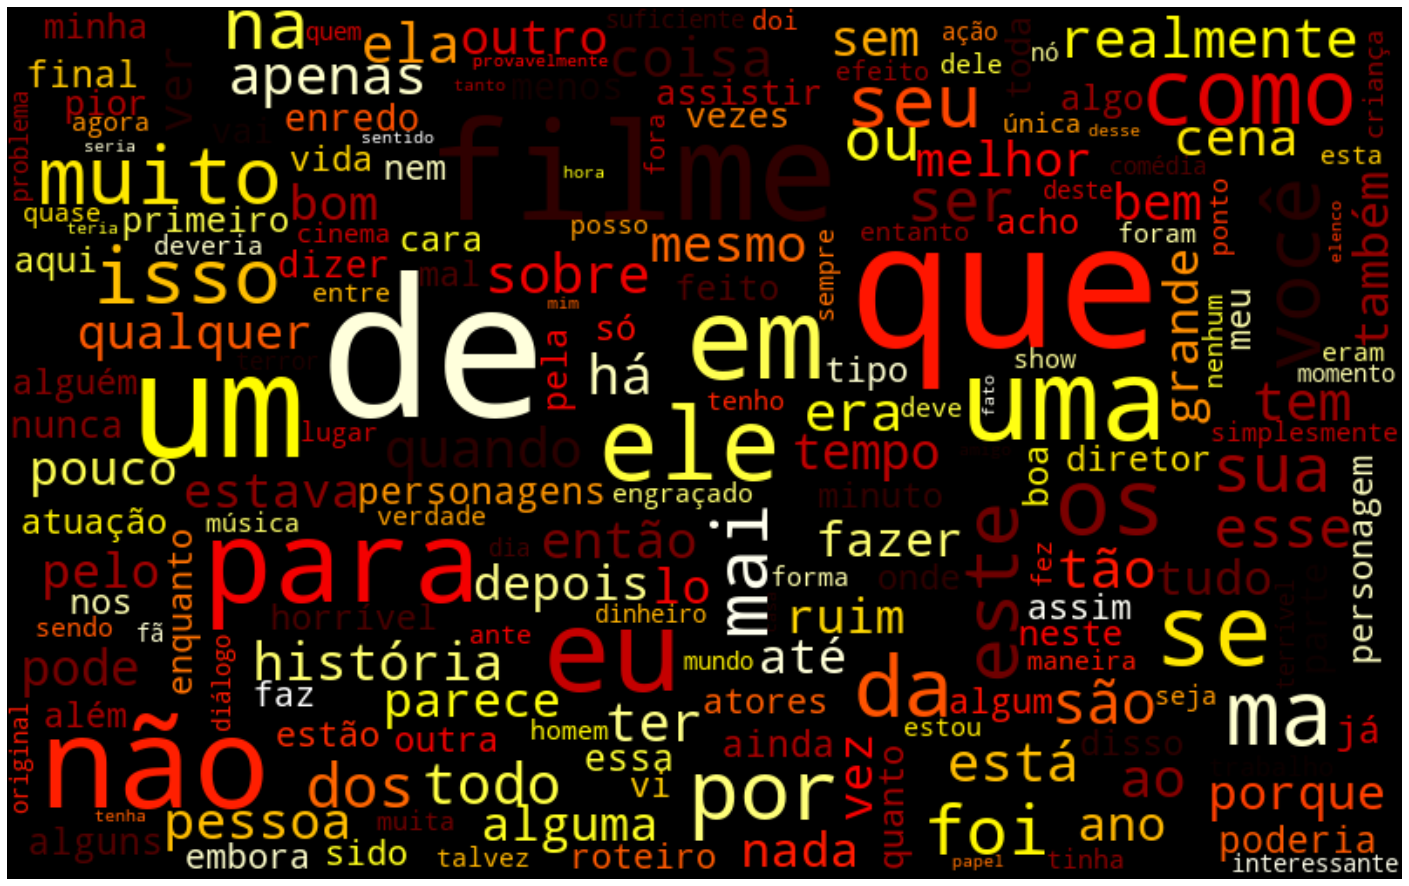

In [62]:
nuvem_palavras_neg(resenha, "text_pt")

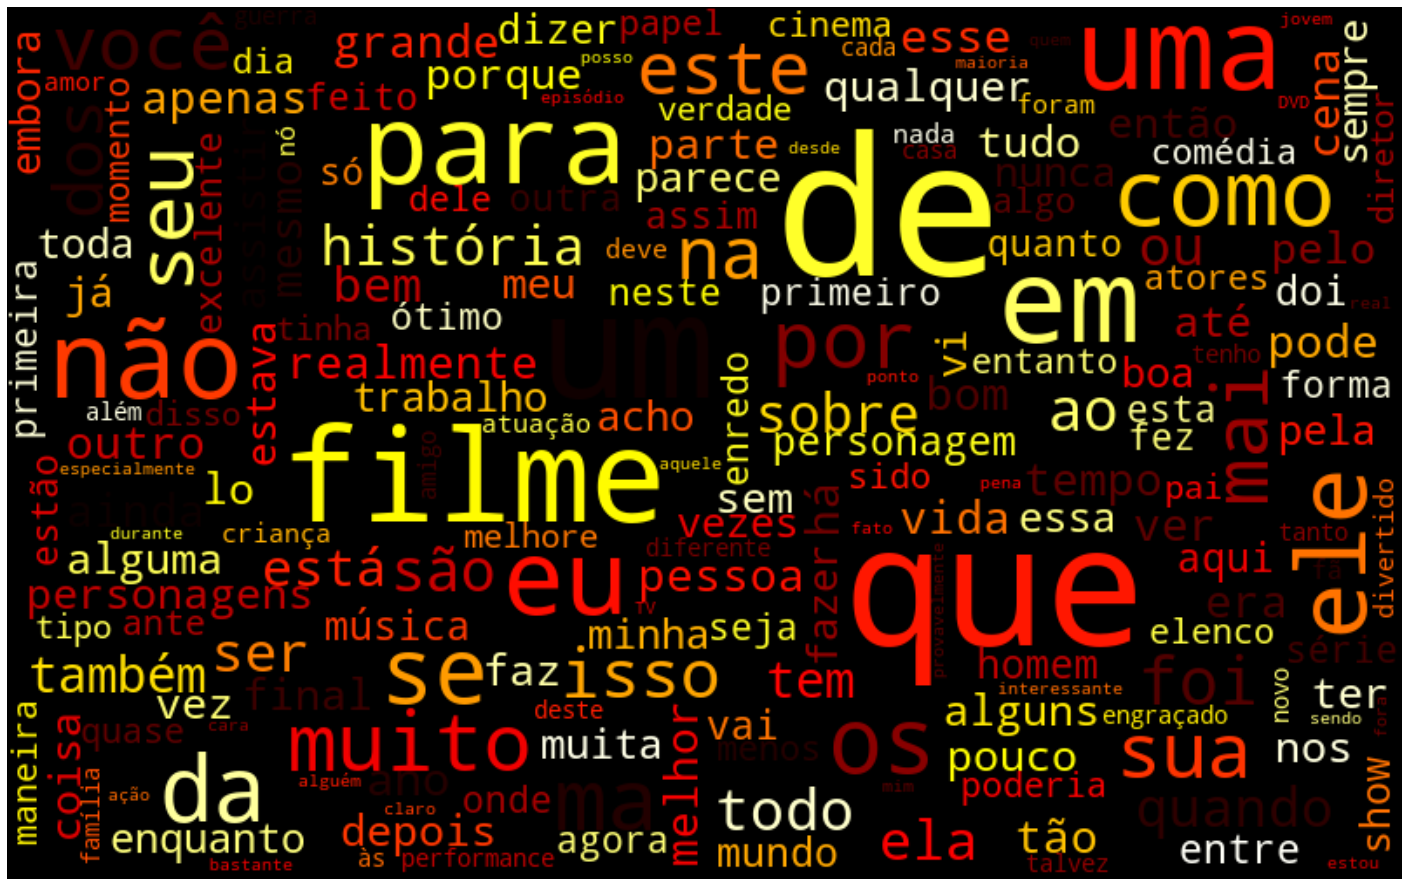

In [63]:
nuvem_palavras_pos(resenha, "text_pt")

# NLTK 

Agora vamos criar uma vizualização pra saber quais são as 20/50 palavras mais utilizadas num conjunto de frases. Para esta tarefa vamos usar a biblioteca em python chamada [NLTK](https://www.nltk.org/) ou Natural Language Toolkit.

Esta biblioteca talvez seja uma das melhores da área NLP, pois em alguns setores da computação geralmente uma biblioteca escrita em alemão funciona bem em inglês, mas se tratando de processamento de linguagem natural isso nem sempre acontece. 

A forma que o português é estruturado é diferente da forma que o alemão é estruturado e isso se reflete nos algorítmos, fazendo com que alguns algorítmos sejam específicos para cada idioma e o NLTK trás suporte para divérsas línguas.

## Instalando 

Para utilizar o NLTK não é diferente de outra biblioteca externa, precisamos instalar 

primeiro precisamos instalar via `pip` e depois baixar os dados com: 

`import nltk `

`nltk.download('all')`

A documentação do NLTK esta aqui:

https://www.nltk.org/py-modindex.html

In [64]:
!pip install nltk

### Freqência

O objetivo agora é analisar quais as palavras que aparecem com maior frequência, pra isso vamos usar uma função chama `nltk.fraqDist()` a descrição dela esta disponível aqui: https://www.nltk.org/api/nltk.html?highlight=freqdist